In [ ]:
%%capture
!test -d ./TCC-EEG && rm -r TCC-EEG
%cd /content/
!git clone https://github.com/TheoMoutakanni/TCC-EEG.git
%cd /content/TCC-EEG/
!pip install -U https://api.github.com/repos/braindecode/braindecode/zipball/master

In [19]:
%load_ext autoreload 
%autoreload 1
%aimport models, utils
from importlib import reload
reload(utils.plot)

<module 'utils.plot' from '/home/theo/Documents/TCC-EEG/utils/plot.py'>

In [1]:
import mne
from braindecode.util import set_random_seeds
from braindecode.datasets.base import BaseConcatDataset
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skorch.callbacks import EpochScoring, ProgressBar
from skorch.helper import predefined_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch

from utils.datasets import get_sleep_physionet, split_dataset, list_of_train_sets
from utils.skorch import EEGTransformer
from utils.linear import plot_knn
from utils.plot import (sleep_cmap, rand_cmap, plot_embeddings, get_ages, get_sleep_stages, get_subjects)
from models.contrastive import ContrastiveModule, EncoderNet, ClassifierNet, train_and_test

# Dataset Creation

In [2]:
%%capture
# full dataset, to get a small one, use: get_sleep_physionet(range(10))
windows_dataset, info = get_sleep_physionet()

In [3]:
self_train_set, self_valid_set, full_train_set, valid_set, test_set, subjects_dic = split_dataset(windows_dataset)
print(len(self_train_set), len(self_valid_set), len(full_train_set), len(valid_set), len(test_set))

114040 16481 130521 18455 18673


In [4]:
mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}
reverse_mapping = {v: k[-1] for k,v in mapping.items()}

In [5]:
sleep_stages = get_sleep_stages(self_valid_set)
ages = get_ages(self_valid_set, info)
subjects = get_subjects(self_valid_set)

# Baseline

## Sleep stages analysis

In [21]:
all_epochs = mne.concatenate_epochs([windows_dataset.datasets[i].windows for i in range(len(windows_dataset.datasets))])

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
167649 matching events found
No baseline correction applied
0 bad epochs dropped


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


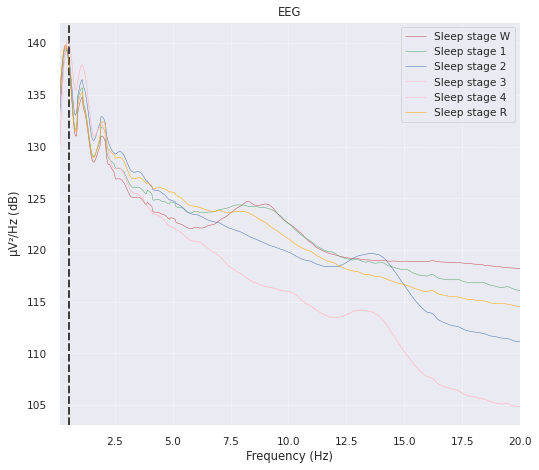

In [120]:
for stage in mapping.keys():
    all_epochs[stage].plot_psd(area_mode=None, color=sleep_cmap(mapping[stage]), ax=plt.gca(),
                           fmin=0.1, fmax=20., show=False, n_jobs=-1,
                           average=True, spatial_colors=False)
plt.legend(plt.gca().lines[2::3], mapping.keys())
plt.savefig('img/freq.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))

## PSD as features

In [22]:
valid_data = np.array([self_valid_set[i][0][0] for i in range(len(self_valid_set))])
fft_data = np.abs(np.fft.fft(valid_data))
fft_data = fft_data.reshape(fft_data.shape[0], -1)

In [23]:
pca_fft = PCA(2)
pca_baseline = pca_fft.fit_transform(fft_data)

tsne_fft = TSNE(2, n_jobs=-1)
tsne_baseline = tsne_fft.fit_transform(fft_data)

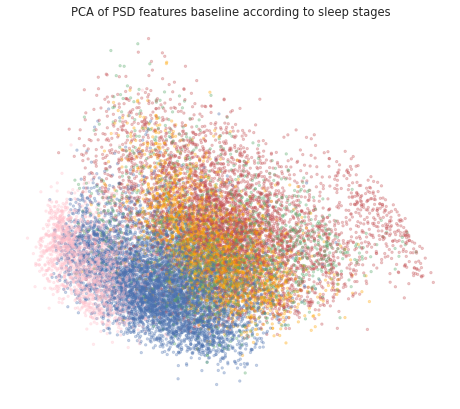

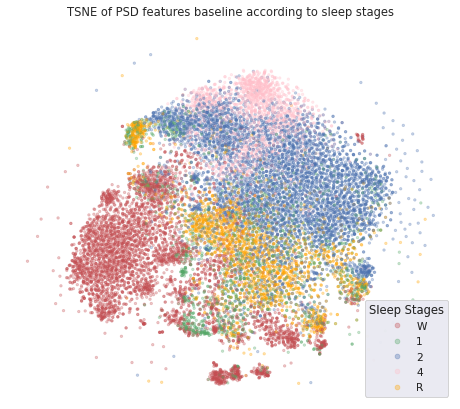

In [24]:
plot_embeddings(pca_baseline, sleep_stages, sleep_cmap, colorbar=False)
plt.savefig('img/PCA_baseline_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("PCA of PSD features baseline according to sleep stages");

plt.figure()
plot_embeddings(tsne_baseline, sleep_stages, sleep_cmap, legend_dict={'title': 'Sleep Stages', 'color_mapping': reverse_mapping}, colorbar=False, legend_loc="lower right")
plt.savefig('img/TSNE_baseline_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("TSNE of PSD features baseline according to sleep stages");

## Using prior knowledge : power band

In [25]:
from scipy import signal

def eeg_power_band(epochs):
    """EEG relative power band feature extraction.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    freqs, psds = signal.welch(epochs, fs=100)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))
    return np.concatenate(X, axis=1)

In [26]:
power_band_data = eeg_power_band(valid_data)

In [27]:
pca_power_band = PCA(2)
pca_baseline_2 = pca_power_band.fit_transform(power_band_data)

tsne_power_band = TSNE(2, n_jobs=-1)
tsne_baseline_2 = tsne_power_band.fit_transform(power_band_data)

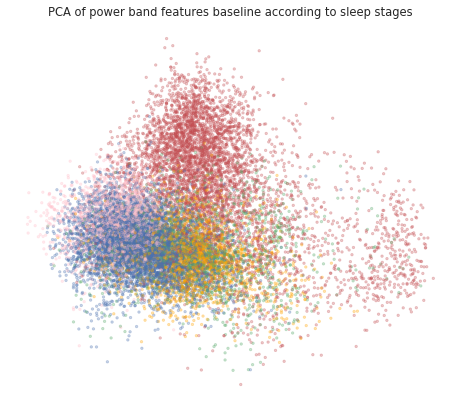

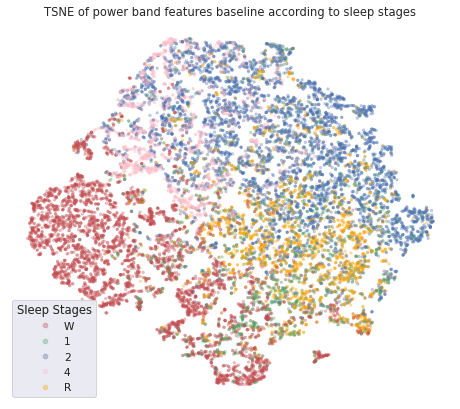

In [28]:
plot_embeddings(pca_baseline_2, sleep_stages, sleep_cmap, colorbar=False)
plt.savefig('img/PCA_baseline_2_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("PCA of power band features baseline according to sleep stages");

plt.figure()
plot_embeddings(tsne_baseline_2, sleep_stages, sleep_cmap, legend_dict={'title': 'Sleep Stages', 'color_mapping': reverse_mapping}, colorbar=False, legend_loc="lower left")
plt.savefig('img/TSNE_baseline_2_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("TSNE of power band features baseline according to sleep stages");

# Contrastive Task Training

## Encoder Training

In [6]:
# Encoder
n_channels = 2
p_dropout = 0.2

encoder = EncoderNet(feat_per_layer=[32, 64, 128], n_channels=n_channels, p_dropout=p_dropout, apply_batch_norm=False)
network = ContrastiveModule(encoder)

In [7]:
network = torch.load('contrastive_network.pt')
encoder = network.encoder
with open('contrastive_network.pkl', 'rb') as f:
    skorch_net = pickle.load(f)

UnpicklingError: pickle data was truncated

In [28]:
#Training
lr = 5e-4
batch_size = 100
max_nb_epochs = 200
early_stopping_patience = 10

skorch_net = network.train_(
    self_train_set, self_valid_set, lr=lr, batch_size=batch_size,
    max_nb_epochs=max_nb_epochs, early_stopping_patience=early_stopping_patience)

  epoch    train_bal_acc    train_loss    valid_bal_acc    valid_loss       dur
-------  ---------------  ------------  ---------------  ------------  --------
      1           0.7589        0.5039           0.7645        0.5116  103.8318


      2           0.7872        0.4615           0.7727        0.4963  91.5647


      3           0.7958        0.4471           0.7630        0.4969  91.0666


      4           0.8004        0.4394           0.7575        0.5121  91.2719


      5           0.8035        0.4332           0.7401        0.5208  91.3171


      6           0.8080        0.4279           0.7476        0.5140  91.6867


      7           0.8102        0.4235           0.7181        0.5491  90.5469


      8           0.8118        0.4203           0.7392        0.5297  90.6297


      9           0.8140        0.4160           0.7654        0.4904  92.9422


     10           0.8146        0.4138           0.7648        0.4892  92.1262


     11           0.8146        0.4133           0.7269        0.5425  92.0218


     12           0.8183        0.4074           0.7171        0.5675  92.1341


     13           0.8177        0.4071           0.7441        0.5242  91.8814


     14           0.8186        0.4072           0.7066        0.5786  92.1148


     15           0.8205        0.4041           0.7415        0.5326  91.7656


     16           0.8203        0.4024           0.7586        0.5107  91.6115


     17           0.8231        0.3986           0.6990        0.5984  91.5315


     18           0.8229        0.3993           0.7176        0.5657  89.0400


     19           0.8236        0.3976           0.7289        0.5551  87.2373


Stopping since valid_loss has not improved in the last 10 epochs.


In [ ]:
torch.save(network, 'contrastive_network.pt')
with open('contrastive_network.pkl', 'wb') as f:
    pickle.dump(skorch_net, f)

## Predictions

In [14]:
# Embeddings
embds = skorch_net.transform(self_valid_set)[::2]
# PCA
pca = PCA(2)
pca_embds = pca.fit_transform(embds)
# TSNE
tsne = TSNE(2, n_jobs=-1)
tsne_embds = tsne.fit_transform(embds)

In [15]:
print('Explained variance (%) for PCA with 2 components: ', pca.explained_variance_ratio_.sum())

Explained variance (%) for PCA with 2 components:  0.71958995


# Plots

In [9]:
new_cmap = rand_cmap(max(subjects)+1, type='bright', first_color_black=True,
                     last_color_black=False, verbose=False)

In [16]:
with open('cmap.pkl', 'rb') as f:
    new_cmap = pickle.load(f)

## Sleep Stages

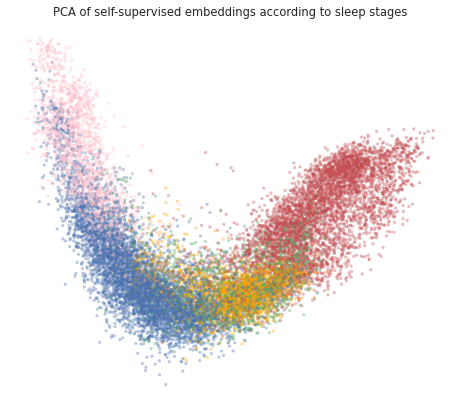

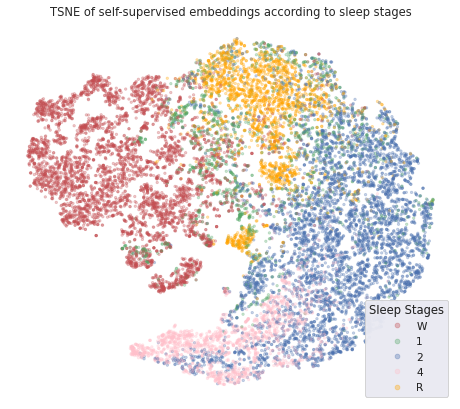

In [17]:
plot_embeddings(pca_embds, sleep_stages, sleep_cmap, colorbar=False)
plt.savefig('img/PCA_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("PCA of self-supervised embeddings according to sleep stages");

plt.figure()
plot_embeddings(tsne_embds, sleep_stages, sleep_cmap, legend_dict={'title': 'Sleep Stages', 'color_mapping': reverse_mapping}, colorbar=False, legend_loc="lower right")
plt.savefig('img/TSNE_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("TSNE of self-supervised embeddings according to sleep stages");

## Age

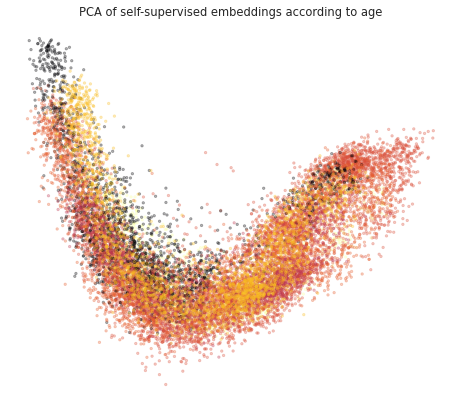

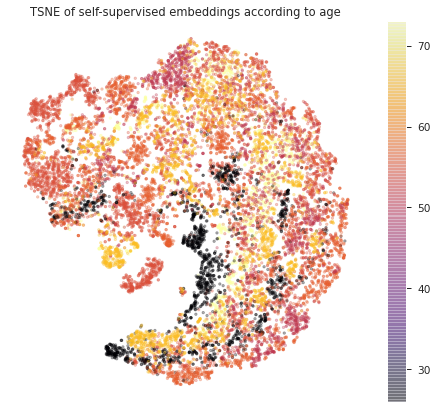

In [18]:
plot_embeddings(pca_embds, ages, plt.get_cmap('inferno'), colorbar=False)
plt.savefig('img/PCA_age.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title('PCA of self-supervised embeddings according to age')

plt.figure()
plot_embeddings(tsne_embds, ages, plt.get_cmap('inferno'))
plt.savefig('img/TSNE_age.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title('TSNE of self-supervised embeddings according to age');

## Patient ID

Text(0.5, 1.0, 'TSNE of self-supervised embeddings according to patient id')

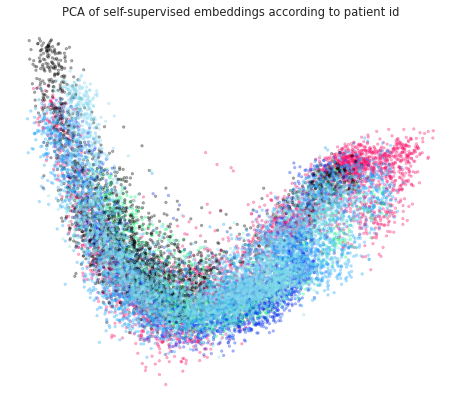

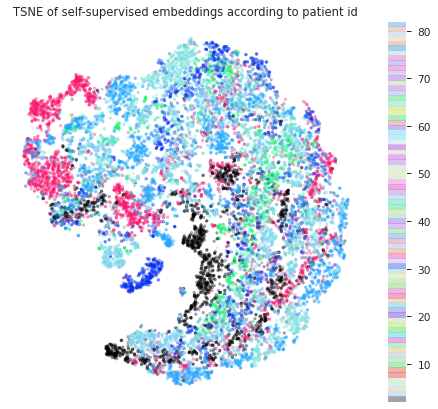

In [19]:
plot_embeddings(pca_embds, subjects, new_cmap, colorbar=False)
plt.savefig('img/PCA_patient.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title('PCA of self-supervised embeddings according to patient id')

plt.figure()
plot_embeddings(tsne_embds, subjects, new_cmap)
plt.savefig('img/TSNE_patient.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title('TSNE of self-supervised embeddings according to patient id')

# Comparison against baseline

100%|██████████| 3/3 [01:26<00:00, 28.75s/it]


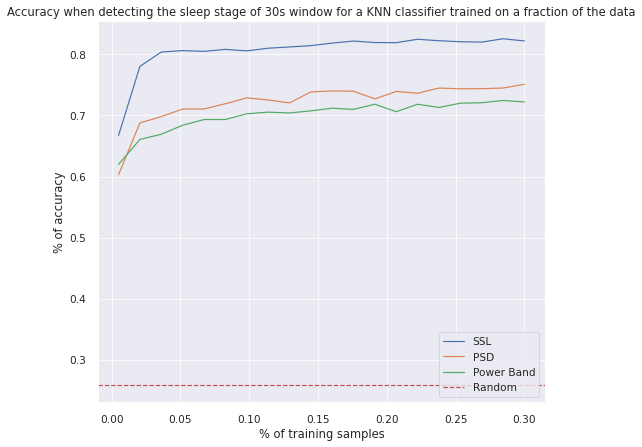

In [29]:
plot_knn([embds, fft_data, power_band_data], sleep_stages, colorbar=False, verbose=1)
plt.legend(['SSL', 'PSD', 'Power Band', 'Random'], loc='lower right')
plt.savefig('img/knn_benchmark_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title('Accuracy when detecting the sleep stage of 30s window for a KNN classifier trained on a fraction of the data');

100%|██████████| 3/3 [01:18<00:00, 26.32s/it]


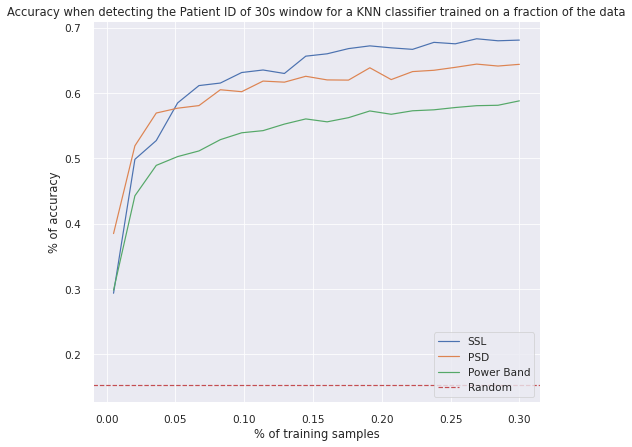

In [30]:
plot_knn([embds, fft_data, power_band_data], subjects, colorbar=False, verbose=1)
plt.legend(['SSL', 'PSD', 'Power Band', 'Random'], loc='lower right')
plt.savefig('img/knn_benchmark_patient.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title('Accuracy when detecting the Patient ID of 30s window for a KNN classifier trained on a fraction of the data');

# Downstream task

In [31]:
train_sets = list_of_train_sets(subjects_dic["full_train_subjects"], windows_dataset)

In [ ]:
lr = 5e-4
batch_size = 64
max_nb_epochs = 100
early_stopping_patience = 10

acc_list = []
for train_set in train_sets[::5]:
    classifier_net = ClassifierNet(encoder, p_dropout=0.2)
    _, acc = train_and_test(classifier_net, train_set, valid_set, test_set=test_set, lr=lr, batch_size=batch_size,
                            max_nb_epochs=max_nb_epochs, early_stopping_patience=early_stopping_patience, train_what="last")
    acc_list.append(acc)

  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4199        1.3050       0.6524           0.4893        1.2750  13.5019


      2           0.4891        1.2044       0.6889           0.5024        1.2362  2.0225


      3           0.4884        1.2018       0.6226           0.4851        1.2812  1.9826


      4           0.4895        1.1948       0.6539           0.4978        1.2539  2.0449


      5           0.4953        1.1912       0.6458           0.4935        1.2581  2.0708


      6           0.4983        1.1836       0.6134           0.4747        1.2836  2.0426


      7           0.5003        1.1882       0.6748           0.5111        1.2331  2.0041


      8           0.4943        1.1895       0.6536           0.4995        1.2490  2.1066


      9           0.5017        1.1814       0.6684           0.5031        1.2360  2.1070


     10           0.4983        1.1850       0.6114           0.4724        1.2828  2.0834


     11           0.5025        1.1812       0.6560           0.4866        1.2430  2.0867


     12           0.4935        1.1852       0.6629           0.4971        1.2374  2.1158


     13           0.5033        1.1787       0.6915           0.5022        1.2162  2.1348


     14           0.5028        1.1786       0.6555           0.4960        1.2442  2.0068


     15           0.4987        1.1809       0.6836           0.5115        1.2222  2.1364


     16           0.4992        1.1823       0.6341           0.4915        1.2642  2.2103


     17           0.5077        1.1757       0.7173           0.5271        1.1917  2.0970


     18           0.5046        1.1785       0.6575           0.4938        1.2414  2.1027


     19           0.4974        1.1841       0.6193           0.4782        1.2776  2.1289


     20           0.5053        1.1786       0.6212           0.4816        1.2752  2.1178


     21           0.4991        1.1786       0.6388           0.4814        1.2573  2.1137


     22           0.5077        1.1744       0.6663           0.4962        1.2327  2.1381


     23           0.5024        1.1813       0.6831           0.5092        1.2194  2.1335


     24           0.5058        1.1771       0.6916           0.5129        1.2125  2.1771


     25           0.5040        1.1775       0.6645           0.4947        1.2347  2.1804


     26           0.5029        1.1800       0.6536           0.4986        1.2450  2.1443


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4810        1.2531       0.6836           0.4956        1.2222  10.3660


      2           0.5094        1.2134       0.6802           0.5055        1.2232  3.2160


      3           0.5146        1.2085       0.6813           0.4894        1.2196  3.2780


      4           0.5152        1.2070       0.6973           0.5179        1.2059  3.2482


      5           0.5155        1.2049       0.6805           0.4990        1.2216  3.2292


      6           0.5184        1.2041       0.6849           0.5127        1.2173  3.3704


      7           0.5178        1.2039       0.6781           0.5118        1.2240  3.2892


      8           0.5173        1.2048       0.6533           0.4909        1.2458  3.2805


      9           0.5208        1.2013       0.6748           0.5061        1.2262  3.2869


     10           0.5160        1.2054       0.6839           0.4983        1.2179  3.3109


     11           0.5198        1.2024       0.6600           0.5030        1.2381  3.3168


     12           0.5169        1.2034       0.6741           0.4974        1.2271  3.3214


     13           0.5182        1.2029       0.6791           0.5094        1.2226  3.3323


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4435        1.2534       0.6541           0.4988        1.2462  14.0207


      2           0.5046        1.2069       0.6760           0.4919        1.2236  4.8002


      3           0.5077        1.2043       0.6523           0.5000        1.2469  4.8334


      4           0.5101        1.2007       0.7119           0.5266        1.1932  4.8666


      5           0.5105        1.2003       0.7144           0.5216        1.1914  4.7539


      6           0.5134        1.1977       0.7138           0.5308        1.1913  4.7280


      7           0.5158        1.1969       0.6834           0.5116        1.2159  4.7423


      8           0.5153        1.1962       0.7291           0.5383        1.1755  4.7914


      9           0.5177        1.1943       0.7263           0.5338        1.1785  4.8218


     10           0.5199        1.1926       0.7024           0.5203        1.1969  5.0770


     11           0.5230        1.1913       0.7058           0.5263        1.1958  4.9690


     12           0.5227        1.1914       0.7261           0.5476        1.1794  5.1089


     13           0.5249        1.1896       0.6994           0.5135        1.2007  5.1555


     14           0.5281        1.1863       0.7161           0.5357        1.1882  5.1702


     15           0.5283        1.1880       0.7393           0.5487        1.1714  5.1939


     16           0.5278        1.1864       0.7523           0.5585        1.1609  5.1653


     17           0.5309        1.1848       0.7202           0.5355        1.1828  5.0435


     18           0.5299        1.1854       0.7299           0.5319        1.1744  5.0580


     19           0.5309        1.1848       0.7306           0.5265        1.1722  4.9500


     20           0.5297        1.1841       0.7452           0.5336        1.1624  5.0046


     21           0.5317        1.1830       0.7266           0.5530        1.1797  5.0900


     22           0.5338        1.1832       0.7459           0.5614        1.1647  5.1866


     23           0.5314        1.1838       0.7524           0.5528        1.1638  5.1205


     24           0.5346        1.1818       0.7319           0.5410        1.1741  4.9972


     25           0.5366        1.1800       0.7511           0.5692        1.1643  5.0015


     26           0.5342        1.1818       0.7390           0.5618        1.1728  5.0883


     27           0.5368        1.1800       0.7561           0.5623        1.1573  5.2253


     28           0.5367        1.1810       0.7264           0.5329        1.1773  5.0091


     29           0.5363        1.1804       0.7553           0.5493        1.1560  4.9346


     30           0.5363        1.1791       0.7525           0.5621        1.1610  4.9832


     31           0.5363        1.1791       0.7492           0.5680        1.1630  4.9663


     32           0.5398        1.1777       0.7308           0.5415        1.1719  5.0831


     33           0.5360        1.1794       0.7280           0.5520        1.1778  5.2378


     34           0.5398        1.1779       0.7378           0.5571        1.1717  5.2371


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.5911        1.1924       0.7181           0.6044        1.1878  12.9695


      2           0.6289        1.1664       0.7481           0.6137        1.1599  6.2564


      3           0.6288        1.1662       0.7351           0.6241        1.1706  6.2770


      4           0.6345        1.1605       0.7212           0.6057        1.1823  6.3627


      5           0.6333        1.1602       0.7044           0.6073        1.1974  6.2313


      6           0.6378        1.1570       0.7507           0.6485        1.1567  6.2366


      7           0.6388        1.1570       0.7051           0.6011        1.1946  6.4952


      8           0.6421        1.1545       0.7199           0.6309        1.1813  6.4442


      9           0.6486        1.1506       0.7127           0.6288        1.1879  6.2768


     10           0.6550        1.1501       0.7034           0.5831        1.1976  6.3066


     11           0.6512        1.1500       0.7242           0.6430        1.1770  6.2449


     12           0.6613        1.1472       0.7396           0.6467        1.1656  6.4829


     13           0.6592        1.1463       0.7176           0.6078        1.1837  6.4841


     14           0.6611        1.1445       0.7500           0.6768        1.1587  6.4573


     15           0.6687        1.1415       0.7270           0.6221        1.1771  6.5307


     16           0.6661        1.1419       0.7618           0.6576        1.1466  6.3681


     17           0.6672        1.1408       0.7248           0.6638        1.1805  6.4289


     18           0.6717        1.1414       0.7347           0.6607        1.1714  6.2989


     19           0.6705        1.1401       0.7225           0.6507        1.1756  6.5640


     20           0.6710        1.1399       0.7532           0.6499        1.1553  6.6264


     21           0.6697        1.1384       0.7212           0.6292        1.1809  6.6963


     22           0.6710        1.1373       0.7499           0.6657        1.1619  6.5893


     23           0.6704        1.1378       0.7355           0.6710        1.1705  6.5979


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4638        1.2403       0.7100           0.5314        1.1961  14.8641


      2           0.5017        1.2106       0.7091           0.5280        1.1973  7.4887


      3           0.5061        1.2070       0.6889           0.5208        1.2149  7.6852


      4           0.5140        1.2023       0.7150           0.5472        1.1898  7.7486


      5           0.5199        1.2008       0.6869           0.5387        1.2142  7.8357


      6           0.5227        1.1974       0.7057           0.5441        1.1974  8.0377


      7           0.5269        1.1948       0.7184           0.5520        1.1880  7.8925


      8           0.5288        1.1935       0.7163           0.5560        1.1896  7.8561


      9           0.5318        1.1921       0.7039           0.5485        1.2022  7.7595


     10           0.5333        1.1901       0.7320           0.5691        1.1826  7.6211


     11           0.5346        1.1888       0.7175           0.5551        1.1909  7.9651


     12           0.5355        1.1872       0.7243           0.5570        1.1880  8.0667


     13           0.5384        1.1855       0.7377           0.5498        1.1715  7.8329


     14           0.5385        1.1860       0.7371           0.5611        1.1787  7.8562


     15           0.5400        1.1847       0.7402           0.5665        1.1745  7.9113


     16           0.5393        1.1840       0.7542           0.5634        1.1589  7.7933


     17           0.5414        1.1837       0.7494           0.5658        1.1631  7.9963


     18           0.5432        1.1825       0.7345           0.5615        1.1740  7.7698


     19           0.5418        1.1831       0.7503           0.5703        1.1587  7.8054


     20           0.5387        1.1845       0.7244           0.5686        1.1860  8.0152


     21           0.5461        1.1811       0.7310           0.5594        1.1758  8.4319


     22           0.5468        1.1801       0.7224           0.5616        1.1863  8.2211


     23           0.5446        1.1820       0.7180           0.5592        1.1853  8.1380


     24           0.5421        1.1817       0.7284           0.5591        1.1821  8.3049


     25           0.5467        1.1799       0.7357           0.5623        1.1761  8.0724


     26           0.5451        1.1799       0.7407           0.5629        1.1658  7.7378


     27           0.5436        1.1804       0.7263           0.5702        1.1848  7.4861


     28           0.5468        1.1795       0.7412           0.5628        1.1668  7.7171


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4790        1.2154       0.7334           0.6158        1.1726  20.8382


      2           0.6210        1.1566       0.7502           0.6307        1.1552  9.3095


      3           0.6250        1.1538       0.7634           0.6249        1.1410  9.4547


      4           0.6289        1.1498       0.7532           0.6149        1.1500  9.2387


      5           0.6320        1.1487       0.7645           0.6158        1.1421  9.2186


      6           0.6373        1.1458       0.7739           0.6550        1.1345  9.6768


      7           0.6386        1.1443       0.7555           0.6258        1.1504  9.3698


      8           0.6375        1.1434       0.7503           0.6443        1.1578  9.7452


      9           0.6487        1.1394       0.7598           0.6234        1.1512  9.5854


     10           0.6452        1.1399       0.7703           0.6609        1.1403  9.7927


     11           0.6504        1.1381       0.7705           0.6638        1.1429  9.8525


     12           0.6494        1.1374       0.7645           0.6289        1.1458  9.7106


     13           0.6515        1.1363       0.7648           0.6645        1.1472  9.7491


     14           0.6509        1.1357       0.7451           0.6670        1.1615  9.6219


     15           0.6532        1.1359       0.7772           0.6535        1.1357  9.3823


     16           0.6595        1.1326       0.7752           0.6502        1.1368  9.9484


     17           0.6575        1.1321       0.7675           0.6484        1.1457  9.9285


     18           0.6563        1.1315       0.7666           0.6612        1.1435  9.8897


     19           0.6555        1.1324       0.7772           0.6557        1.1362  9.5074


     20           0.6562        1.1309       0.7694           0.6428        1.1416  9.7461


     21           0.6555        1.1318       0.7641           0.6423        1.1439  9.8755


     22           0.6586        1.1303       0.7668           0.6302        1.1441  9.8824


     23           0.6595        1.1298       0.7358           0.6412        1.1691  9.9000


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4847        1.1972       0.7323           0.5388        1.1759  20.5085


      2           0.5135        1.1792       0.7239           0.5549        1.1848  10.3686


      3           0.5233        1.1748       0.7136           0.5446        1.1890  10.9304


      4           0.5257        1.1724       0.7261           0.5501        1.1768  10.9072


      5           0.5299        1.1694       0.7281           0.5497        1.1819  11.1181


      6           0.5338        1.1668       0.7471           0.5679        1.1642  10.6284


      7           0.5388        1.1642       0.7457           0.5666        1.1650  10.6436


      8           0.5392        1.1631       0.7541           0.5582        1.1586  11.2115


      9           0.5398        1.1625       0.7481           0.5639        1.1665  11.1626


     10           0.5431        1.1605       0.7512           0.5749        1.1631  10.9607


     11           0.5426        1.1593       0.7571           0.5662        1.1590  11.0223


     12           0.5446        1.1586       0.7591           0.5642        1.1508  11.3546


     13           0.5459        1.1577       0.7406           0.5574        1.1660  11.4693


     14           0.5469        1.1568       0.7555           0.5744        1.1582  11.4844


     15           0.5474        1.1564       0.7533           0.5516        1.1572  11.0857


     16           0.5491        1.1556       0.7523           0.5738        1.1597  11.0353


     17           0.5481        1.1554       0.7492           0.5635        1.1595  11.1431


     18           0.5498        1.1550       0.7479           0.5722        1.1609  11.2134


     19           0.5504        1.1549       0.7509           0.5802        1.1580  10.9998


     20           0.5467        1.1558       0.7520           0.5706        1.1577  11.2009


     21           0.5505        1.1542       0.7565           0.5649        1.1534  11.0742


     22           0.5511        1.1545       0.7525           0.5692        1.1537  11.2741


     23           0.5518        1.1543       0.7454           0.5736        1.1613  11.3861


     24           0.5505        1.1538       0.7535           0.5797        1.1559  11.0899


     25           0.5521        1.1524       0.7535           0.5643        1.1520  11.3443


     26           0.5519        1.1530       0.7564           0.5759        1.1524  10.9714


     27           0.5529        1.1529       0.7450           0.5423        1.1609  11.0670


     28           0.5521        1.1522       0.7559           0.5773        1.1518  11.4693


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4994        1.1983       0.7217           0.5412        1.1818  39.8905


      2           0.5169        1.1845       0.7261           0.5406        1.1767  11.7385


      3           0.5227        1.1805       0.7393           0.5482        1.1662  12.1302


      4           0.5257        1.1784       0.7341           0.5504        1.1717  12.4360


      5           0.5285        1.1761       0.7493           0.5570        1.1574  12.1928


      6           0.5302        1.1735       0.7336           0.5744        1.1812  12.3121


      7           0.5319        1.1727       0.7448           0.5697        1.1697  12.0657


      8           0.5352        1.1707       0.7500           0.5657        1.1626  12.5818


      9           0.5385        1.1686       0.7471           0.5625        1.1616  12.6998


     10           0.5400        1.1681       0.7426           0.5752        1.1692  12.8186


     11           0.5422        1.1669       0.7580           0.5788        1.1572  12.2035


     12           0.5412        1.1662       0.7486           0.5745        1.1613  12.1399


     13           0.5413        1.1663       0.7543           0.5777        1.1594  13.0104


     14           0.5422        1.1648       0.7445           0.5600        1.1636  12.4677


     15           0.5421        1.1647       0.7546           0.5541        1.1547  12.2843


     16           0.5449        1.1636       0.7509           0.5717        1.1610  12.5925


     17           0.5450        1.1631       0.7531           0.5596        1.1566  12.4214


     18           0.5440        1.1637       0.7297           0.5604        1.1768  12.4652


     19           0.5434        1.1649       0.7498           0.5449        1.1575  12.8513


     20           0.5487        1.1617       0.7486           0.5649        1.1578  12.7437


Stopping since valid_bal_acc has not improved in the last 10 epochs.


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.5904        1.1778       0.7535           0.6148        1.1542  72.7467


      2           0.6089        1.1636       0.7261           0.5868        1.1777  12.6886


      3           0.6210        1.1585       0.7487           0.6330        1.1561  13.5432


      4           0.6297        1.1544       0.7549           0.6072        1.1494  13.4804


      5           0.6297        1.1528       0.7707           0.6789        1.1389  14.1171


      6           0.6331        1.1504       0.7755           0.6446        1.1344  14.0250


      7           0.6416        1.1479       0.7768           0.6285        1.1318  13.7711


      8           0.6397        1.1462       0.7789           0.6540        1.1321  13.6572


      9           0.6433        1.1446       0.7677           0.6409        1.1423  14.1377


     10           0.6466        1.1436       0.7734           0.6524        1.1398  13.5994


     11           0.6467        1.1431       0.7781           0.6597        1.1340  13.9023


     12           0.6470        1.1418       0.7826           0.6580        1.1287  14.0267


     13           0.6499        1.1406       0.7825           0.6627        1.1285  14.2096


     14           0.6501        1.1408       0.7837           0.6500        1.1301  13.6917


Stopping since valid_bal_acc has not improved in the last 10 epochs.


In [ ]:
nb_patients = [(1 + i*5) for i in range(len(subjects_dic["full_train_subjects"][::5]))]
nb_windows = [len(train_set) for train_set in train_sets[::5]]


# To add the number of windows
# fig, ax1 = plt.subplots(figsize=(10,6))
# ax1.plot(nb_patients, acc, marker="o");
# ax1.set_xlabel('Number of patients', fontsize=16)
# ax1.set_ylabel('Test accuracy', fontsize=16)
# ax1.set_title('Test accuracy of sleep staging', fontsize=18)
# ax2 = ax1.secondary_xaxis('top')
# ax2.set_xlabel('Number of windows', fontsize=16)
# ax2.set_xticklabels(nb_windows)
# plt.show()


plt.figure(figsize=(10,6));
plt.plot(nb_patients, acc_list, marker="o");
plt.xlabel("Number of patients", fontsize=16);
plt.ylabel("Test accuracy", fontsize=16);
plt.savefig('img/fine_tune.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title("Test accuracy of sleep staging", fontsize=18);

In [ ]:
lr = 5e-4
batch_size = 64
max_nb_epochs = 40
early_stopping_patience = 5

acc_list_scratch = []
for train_set in train_sets[::5]:
    classifier_net = ClassifierNet(EncoderNet(feat_per_layer=[32, 64, 128], n_channels=2, p_dropout=0.2, apply_batch_norm=True),
                                   p_dropout=0.2)
    _, acc = train_and_test(classifier_net, train_set, valid_set, test_set=test_set, lr=lr, batch_size=batch_size,
                            max_nb_epochs=max_nb_epochs, early_stopping_patience=early_stopping_patience, train_what="all")
    acc_list_scratch.append(acc)

In [ ]:
plt.figure(figsize=(10,6));
plt.plot(nb_patients, acc_list, marker="o");
plt.plot(nb_patients, acc_list_scratch, marker="o");
plt.xlabel("Number of patients", fontsize=16);
plt.ylabel("Test accuracy", fontsize=16);
plt.legend(['pre-training', 'from scratch'])
plt.savefig('img/fine_tune.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title("Test accuracy of sleep staging", fontsize=18);